# Integrated gradients 

### **The IntegratedGradients method**

Integrated Gradients is a visualization technique resulting of a theoretical search for an explanatory method that satisfies two axioms, Sensitivity and Implementation Invariance (Sundararajan et al.).

<a href="https://arxiv.org/abs/1703.01365"> Sundararajan et al. 2017</a>: "*We consider the straightline path (in $R^n$) from the baseline $\bar{x}$ to the input $x$, and compute the gradients at all points along the path. Integrated gradients are obtained by cumulating these gradients.*"

Rather than calculating only the gradient relative to the image, the method consists of averaging the gradient values along the path from a baseline state to the current input sample $x$. The baseline state is often set to zero, representing the complete absence of features.

More precisely, with $\bar{x}$ the baseline state, $x$ the image, $c$ the class of interest and $S_c$ the unormalized class score (layer before softmax). The Integrated Gradient is defined as

$$IG(x) = (x - \bar{x}) \cdot \int_0^1{ \frac { \partial{S_c(\bar{x} + \alpha(x - \bar{x}))} } { \partial{x} } d\alpha }$$

In order to approximate from a finite number of steps, the implementation here use the Trapezoidal rule (<a href="https://en.wikipedia.org/wiki/Trapezoidal_rule">wikipedia</a>)  and not a left-Riemann summation, which allows for more accurate results and improved performance. (see <a href="https://arxiv.org/abs/1908.06214">Sotoudeh et Thakur - 2019</a> for a comparison of the methods).

Vanilla gradients, while a useful starting point for understanding how pixels contribute to image classification, can be susceptible to noise and may sometimes lose sight of the bigger picture regarding, which image regions are really important. Integrated gradients address these shortcomings by offering a more holistic view. They consider how the model's predictions change along a path transitioning from a neutral baseline image to the actual input image.

Let us unpack this idea. We begin by establishing a simple baseline image – think of it as a blank canvas. This could be a completely black image signifying the absence of visual information, or perhaps one filled entirely with a neutral gray color. Conceptually, picture a straight line (in the high-dimensional space of image pixels) connecting this baseline with the final input image. Integrated gradients do not just analyze the input image in isolation, but instead sample multiple points along this line, calculating gradients at each point. Recall that a gradient indicates how much a tiny change in pixel value would affect the model's prediction score (like the ‘cat' score). Integrated Gradients then accumulate these gradients across all the sampled steps. This accumulation smooths out noise and provides a more robust measure of how influential each pixel is in the classification process.

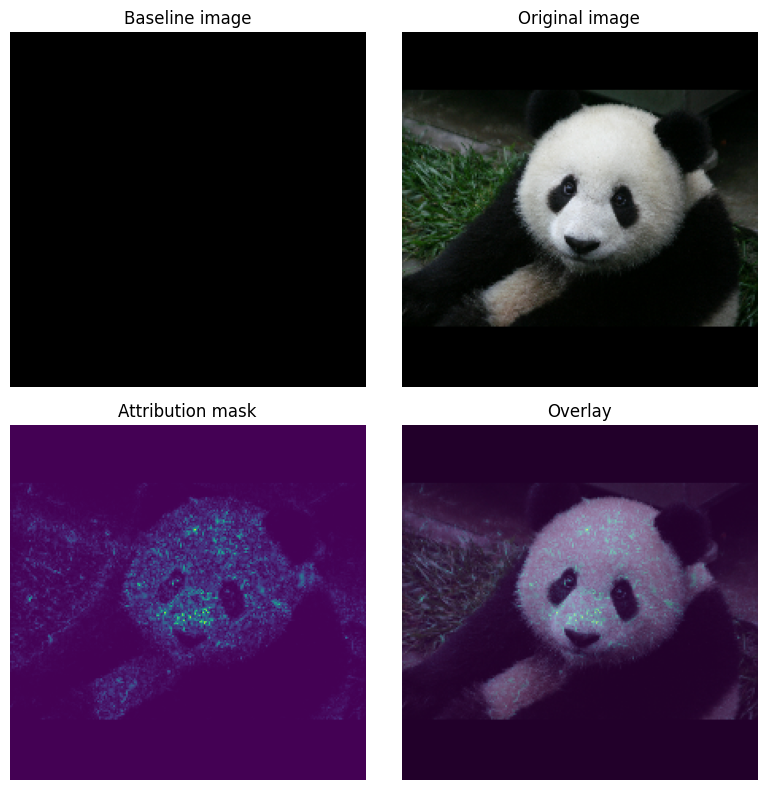

_Figure 2. Interpolated images between a black baseline image and the example ‘Panda' image._

An important feature of integrated gradients lies in how they handle saturation. Imagine a very bright patch of fur near our cat's ear. In the final image, those pixels might be fully saturated, meaning making them even brighter will not drastically change the model's ‘cat' prediction. With vanilla gradients, this could misleadingly suggest that the bright fur patch is not important.

However, integrated gradients take the complete journey into account. As we move along the path from our baseline, earlier steps have those fur pixels at lower brightness levels, where they are not yet saturated. The gradients captured at these stages reveal the true impact those pixels have on nudging the model towards the ‘cat' classification.

Finally, integrated gradients add up the gradients from all these steps. This helps to average out noise and gives us a clearer picture of how important each pixel is for the final classification. It ensures that even seemingly saturated pixels are recognized if they played a key role earlier on in the transition from the baseline.

__Step 1:__ Load the required libraries.

In [3]:
import os
import numpy as np
import tensorflow
import skimage as ski
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import concurrent.futures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import MaxPooling2D, Dropout
from keras.optimizers import Adam
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from math import ceil
from time import time
import xplique
from xplique.attributions import IntegratedGradients
from xplique.plots import plot_attributions

### **IntegratedGradients attributes overview**

As most methods of the Xplique library, an explanation method have a few number of attributes (and their default values) useful to increase your explanation quality.

```python
explainer = IntegratedGradients(model,
                                output_layer: int = -1,
                                batch_size: int = 32,
                                steps: int = 50,
                                baseline_value: float = .0)
```

- The `output_layer` parameter is the index of the output layer corresponding to the label layer. The last layer layers can be activated (linear, softmax ...).

- The `batch_size` define the number of inputs to treat simultaneously. (Positive integer).

- The `steps` parameter is the number of points to interpolate between the baseline and the desired point. The value of `steps` has an linear impact on the simulation time. (Positive integer).

- The `baseline_value` parameter is a scalar used to create the baseline point.

The choices of `steps` and `baseline_value` are related to each other.

The detail on each attribute influence will be provided in the [Parameters influence](#influence) section.

### **Parameters tuning tips**
- The `output_layer` represent the index of the layer from which begin the back-propagation. It should be left to -1, i.e the last layer of the model or the class activation layer.
- The `batch_size` represent the number of perturbed images treated simultaneously. It has an impact on the memory usage. You may use the batch size from your model training.
- The `steps` parameter is the number of points to interpolate between the baseline and the desired point. The right setting is the smallest value after which the explanation are stable. This means that more points will not make the explanation more precise. `steps` default value is 50.

- The `baseline_value` parameter is a scalar used to create the baseline point. It should represent non-information. 0 or the mean of your values are often good values.

:bell: You are free to add any library you deem necessary to successfully complete this homework assignment!

For this tutorial, we will use a Cats vs. Dogs dataset, which consists of images featuring the two distinct animal classes. To make data preprocessing easier, we have already organized the images into separate folders. You will find a 'train' folder containing images used to train your model and a 'test' folder with images for evaluating your model's performance. You can download the preprocessed dataset, [here](https://edubuas-my.sharepoint.com/:f:/g/personal/blerck_i_buas_nl/Egas9AxZzg1MrAE8f8RtErwB1Xy1CKhaNiHQX9hJjTT4Ew?e=WbD2Md). 

__Step 2:__ Download the Cats vs. Dogs dataset, and and assign the paths to the train and test set folders to the variables ```src_path_train``` and ```src_path_train```. 

In [2]:
src_path_train = '/cats_and_dogs/train' # e.g., './cats_and_dogs/train'
src_path_test = '/cats_and_dogs/test'  # e.g., './cats_and_dogs/test'

# THE IMAGES WERE NOT SEPARATED SO I HAD TO MANUALLY SPLIT THEM

__Step 3:__ Pre-process your data: 

- Rescale the images to have pixel values between 0 and 1.
- Resize the images to 224x224 pixels.
- Ensure that the images are in the correct format (e.g., RGB).
- One-hot encode the labels.
- Apply other preprocessing steps, such as horizontal flip and zoom, as necessary. 

In [41]:
# Folder paths where the images of each class are stored
folder_paths = ['cats_and_dogs/cats','cats_and_dogs/dogs']

# Class labels for the images (same order as folder_paths)
class_names = ["cats", 'dogs']

# Target size to resize the images
target_size = (224, 224)

# Arrays to store the images (X) and class labels (y)
X = []
y = []

for i in range(len(folder_paths)):
    for filename in os.listdir(folder_paths[i]):
        file_extension = os.path.splitext(filename)[1]
        # Check if the file extension is an image extension 
        if file_extension == ".jpg" or file_extension == ".jpeg" or file_extension == ".png": 
            image_filename = os.path.join(folder_paths[i], filename)
            # Read the image file using scikit-image
            image = ski.io.imread(image_filename)
            # Normalize the image to values between 0 and 1
            image = image / 255.0
            # Resize the image to the target_size
            image_resized = ski.transform.resize(image, target_size)            
            # Insert the image into array X
            X.append(image_resized)
            # Insert the class label into array y
            y.append(class_names[i])
            
# Convert of arrays into numpy arrays
X = np.array(X)
y = np.array(y)

_Applied data augmentation preprocessing techniques_

In [42]:
data_gen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             zoom_range=0.2)

def GenerateImages(generator, image, num_images):
    new_images = []
    # we need to reshape the image because the generator.flow() 
    # expects an array of images
    image = np.reshape(image, (1,) + image.shape)
    for _ in range(num_images):
        batch = next(generator.flow(image, batch_size=1))
        new_images.append(batch[0])
    return np.array(new_images)

# Save the images to a new dataset 'X_augmented' and 'y_augmented'
X_augmented = []
y_augmented = []
for index in range(len(X)):
    images = GenerateImages(data_gen, X[index], 6)
    for i in range(6):
        X_augmented.append(images[i])
        y_augmented.append(y[index])  

# Convert lists to numpy arrays
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

# Encode the class labels into integers
label_encoder = LabelEncoder()
y_integer_encoded = label_encoder.fit_transform(y_augmented)  
num_classes = len(np.unique(y_integer_encoded))
y_onehot_encoded = keras.utils.to_categorical(y_integer_encoded, num_classes=num_classes)

__Step 4:__ Split your dataset into an 80% training set, 10% validation set, and 10% test set, and assign the sets to the following variables as a numpy array: ```X_train```, ```X_val```, ```X_test```, ```y_train```, ```y_val```, and ```y_test```.

In [43]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented,
                                                    y_onehot_encoded,
                                                    test_size=1/10,
                                                    random_state=0)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = 1/10,
                                                  random_state = 0)

__Step 5:__ Design a Sequential model using the Keras API. Include at least one Conv2D layer for feature extraction, a Flatten layer to prepare the data for classification, and two Dense layers. Leave the second-to-last Dense layer without an activation function, but apply a softmax activation to the final output layer.

In [44]:
# Create a sequential model
model = Sequential()

# Add convolutional layers, max pooling, and dropout layers
model.add(Conv2D(10, kernel_size=3, activation='relu', input_shape=target_size + (3,), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(10, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(2, activation='softmax'))

__Step 6:__ Compile your model, and train it using the training and validation sets.

In [45]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a callback to monitor val_accuracy
monitor_val_acc = EarlyStopping(monitor='val_accuracy', 
                       patience=3)

# Train the model 
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=monitor_val_acc)

Epoch 1/100
456/456 [==============================] - 72s 156ms/step - loss: 0.6818 - accuracy: 0.6029 - val_loss: 0.6333 - val_accuracy: 0.6364
Epoch 2/100
456/456 [==============================] - 77s 168ms/step - loss: 0.5903 - accuracy: 0.6854 - val_loss: 0.5884 - val_accuracy: 0.6926
Epoch 3/100
456/456 [==============================] - 79s 172ms/step - loss: 0.5073 - accuracy: 0.7514 - val_loss: 0.5839 - val_accuracy: 0.6988
Epoch 4/100
456/456 [==============================] - 79s 174ms/step - loss: 0.3965 - accuracy: 0.8177 - val_loss: 0.6981 - val_accuracy: 0.6821
Epoch 5/100
456/456 [==============================] - 87s 190ms/step - loss: 0.2633 - accuracy: 0.8915 - val_loss: 0.8810 - val_accuracy: 0.6735
Epoch 6/100
456/456 [==============================] - 90s 197ms/step - loss: 0.1327 - accuracy: 0.9510 - val_loss: 1.1785 - val_accuracy: 0.6586


In [69]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 10)      280       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 10)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 110, 110, 10)      910       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 55, 55, 10)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 30250)             0         
                                                                 
 dense_9 (Dense)             (None, 128)              

: 

### **IntegratedGradients simple utilization**

This a minimal example on how to apply the IntegratedGradients method. This focus on the right specification of the IntegratedGradients method parameters. For further details and explanations on the attribution explainers API, please refer to the [Feature attribution tutorial](https://colab.research.google.com/drive/1XproaVxXjO9nrBSyyy7BuKJ1vy21iHs2)

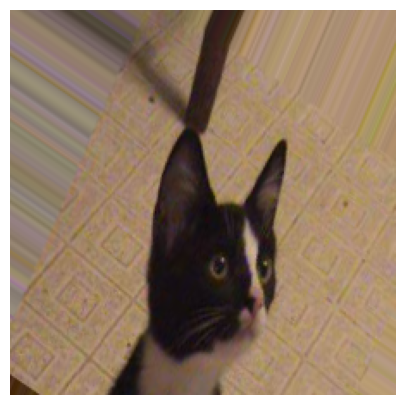

In [54]:
x = np.expand_dims(X_test[0], axis=0)  # Expand dimension for image
y = np.expand_dims(tf.keras.utils.to_categorical(1, 2), axis=0)

plt.rcParams["figure.figsize"] = [12.5, 5]
plt.imshow(x[0])
plt.axis('off')
plt.show()

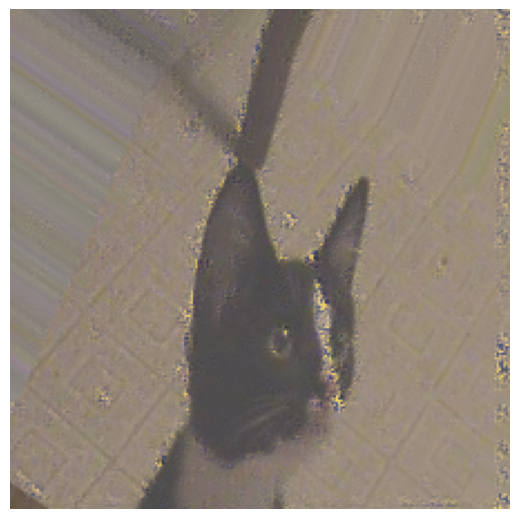

In [55]:
# instanciate explainer with arbitrary parameters
explainer = IntegratedGradients(model,
                                output_layer=-2, batch_size=16,
                                steps=50, baseline_value=0)

# compute explanation by calling the explainer
explanation = explainer.explain(x, y)

# visualize explanation with plot_explanation() function
plot_attributions(explanation, x, img_size=5, cmap='cividis', cols=1, alpha=0.6)

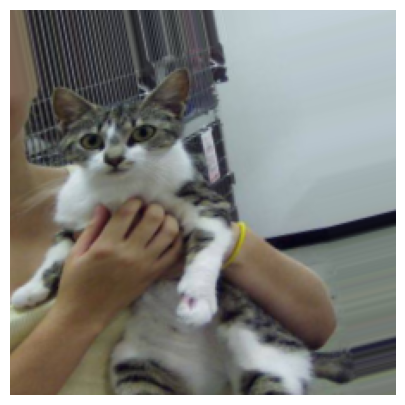

In [61]:
x = np.expand_dims(X_test[100], axis=0)  # Expand dimension for image
y = np.expand_dims(tf.keras.utils.to_categorical(1, 2), axis=0)

plt.rcParams["figure.figsize"] = [12.5, 5]
plt.imshow(x[0])
plt.axis('off')
plt.show()

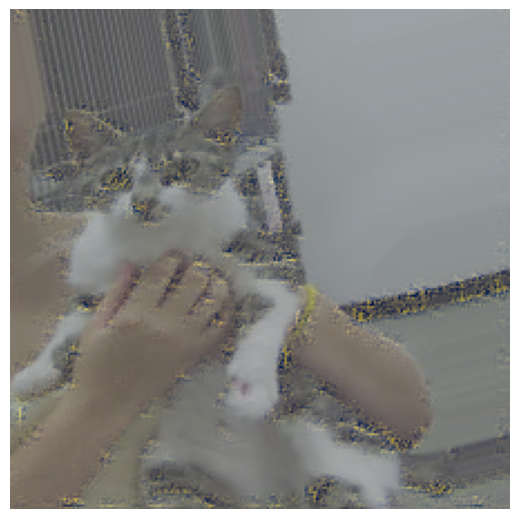

In [62]:
# compute explanation by calling the explainer
explanation = explainer.explain(x, y)

# visualize explanation with plot_explanation() function
plot_attributions(explanation, x, img_size=5, cmap='cividis', cols=1, alpha=0.6)

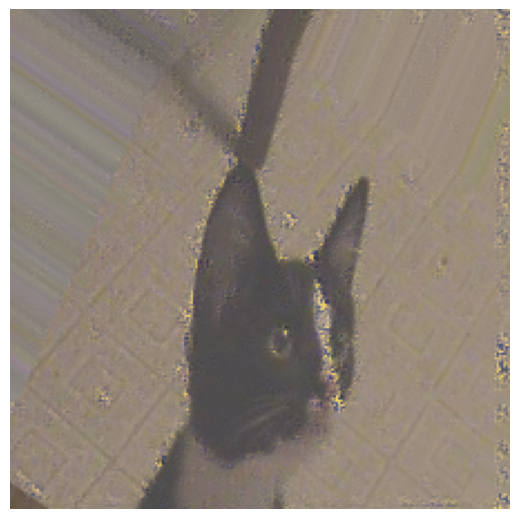

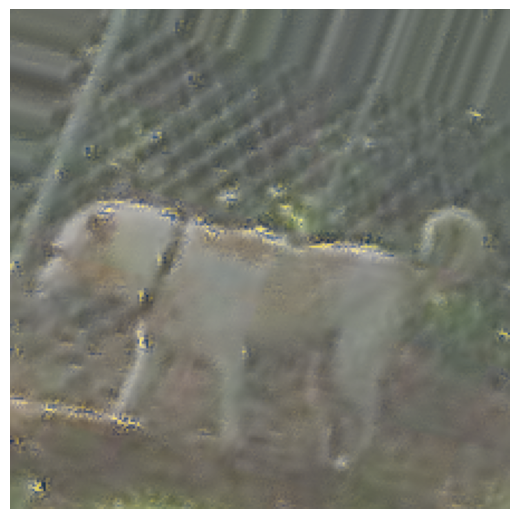

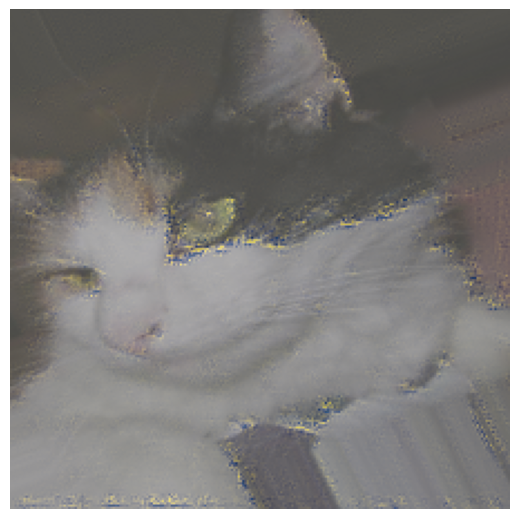

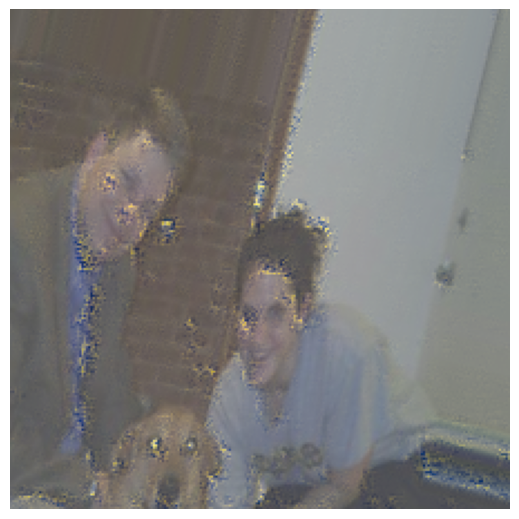

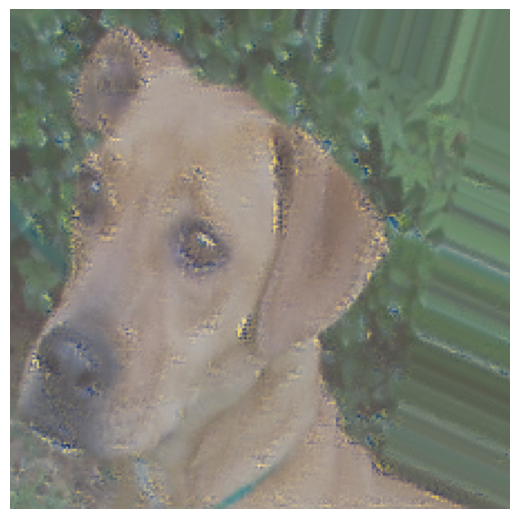

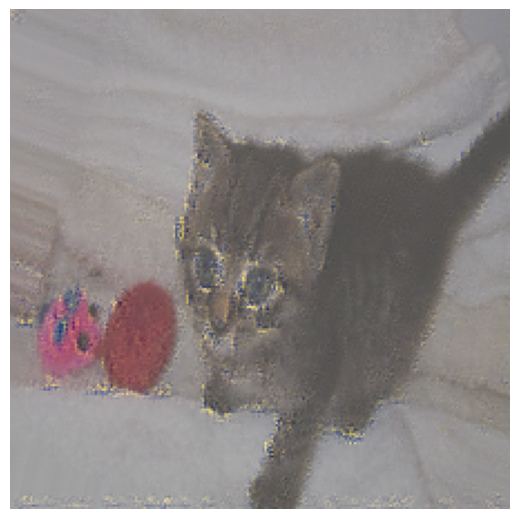

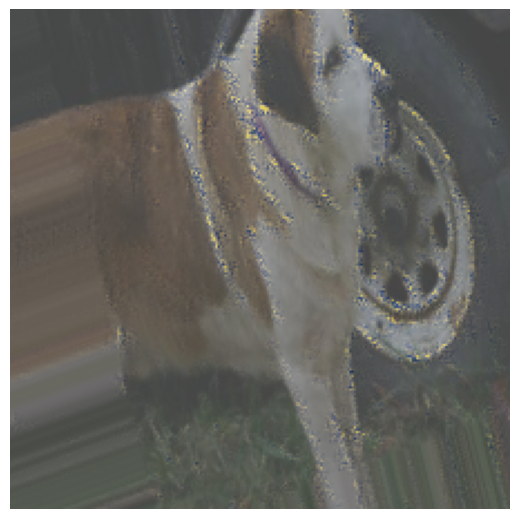

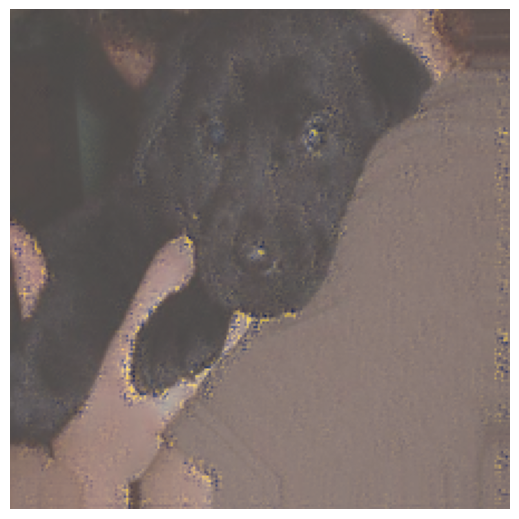

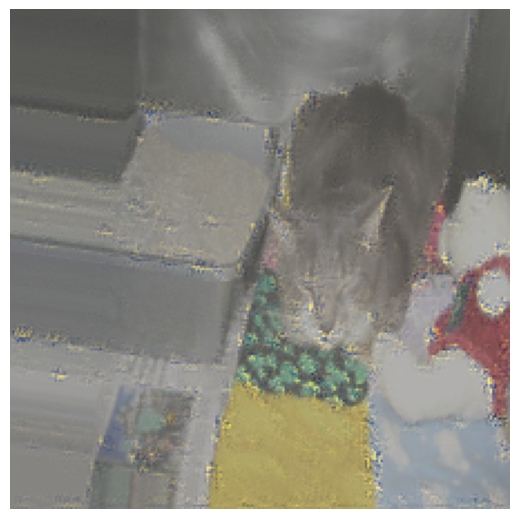

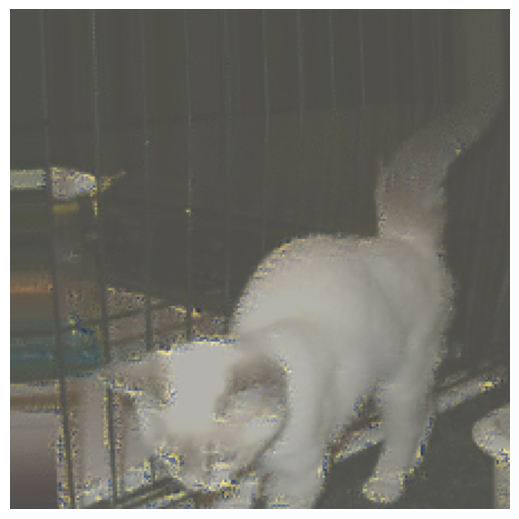

In [68]:
explanation = []
for i in range(10):
    x = np.expand_dims(X_test[i], axis=0)  # Expand dimension for batch
    y = np.expand_dims(tf.keras.utils.to_categorical(1, 2), axis=0)

    # compute explanation by calling the explainer
    explanation = explainer.explain(x, y)

    # visualize explanation with plot_explanation() function
    plot_attributions(explanation, x, img_size=5, cmap='cividis', cols=1, alpha=0.6)

The IntegratedGradients method needs a little bit of knowledge to use it to its full potential by choosing the adaptative parameters (see the [paper](https://arxiv.org/abs/1311.2901)). Therefore we propose to summarize those informations in [the parameters tuning tips part](#tips). The parameters are described and explained in the following sections.

### **IntegratedGradients parameters influence**

### **output_layer**

The `output_layer` parameter is an integer indexing the layer from which to begin the back-propagations. The different papers consider the last layer of the neural neural which is the class activation layer. (The methods can also be applied to regression methods, please see the corresponding tutorial from the <a href="https://deel-ai.github.io/xplique/tutorials/"> list of Xplique tutorials</a>).

To come back to the `output_layer` parameter, we suggest not to change it as the resulting attributions would not be easily interpretable and may be misleading.

### **batch_size**

The `batch_size` parameter should be a positive integer, it indicates the number of perturbed images treated simultaneously.
- Too small values will increase the execution time.
- Too huge values may lead to out of memory errors.
This parameter should be set taking into account your hardware and the image size. The most simple solution is to used the same batch size you use during the training of your model.

### **baseline_value**

The `baseline_value` parameter refers to the baseline state defined in [the method definition](#intro). The given value is used to create the whole baseline image. It should represent non-information, as such, 0 is often used. The value should be in the range of features possible values, (between 0 and 1 for pixels for example).

However, many values could make sense, the mean or median of your features, the minimum or maximum of your features or even the middle between minimum and maximum.

baseline_value: 0


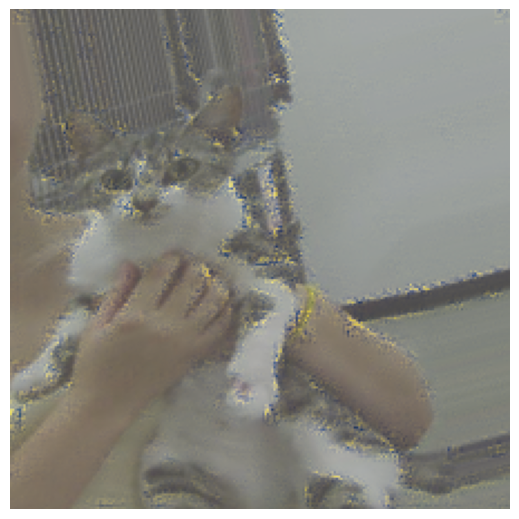

baseline_value: 0.5


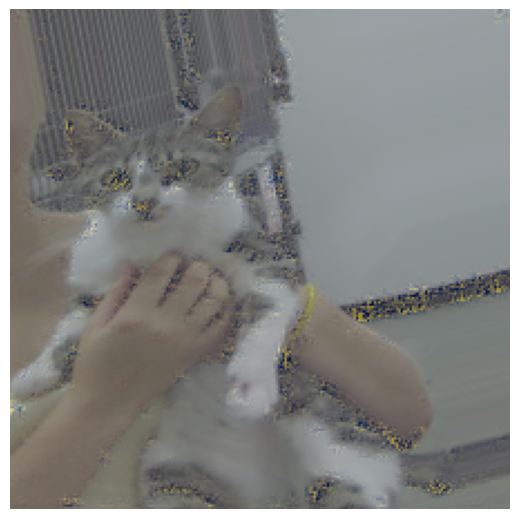

baseline_value: 1


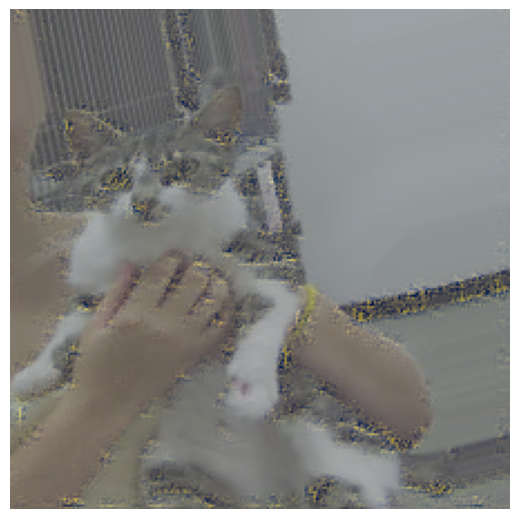

In [63]:
output_layer = -2
batch_size = 32
steps = 50
baseline_values = [0, 0.5, 1]

for baseline_value in baseline_values:
    explainer = IntegratedGradients(model,
                                    output_layer=output_layer, batch_size=batch_size,
                                    steps=steps, baseline_value=baseline_value)

    explanation = explainer.explain(x, y)

    print("baseline_value:", baseline_value)
    plot_attributions(explanation, x, img_size=5, cmap='cividis', alpha=0.6)
    plt.show()

### **steps**

The `steps` parameter is the number of elements used to compute the integration though the trapezoide rule as defined in [the method definition](#intro).

- A too small value of `steps` will not make a good estimator of the integral.
- While a too huge value will take much more time to compute.

The `steps` parameter should increased till convergence of the method.

steps: 2 -> 0.1s


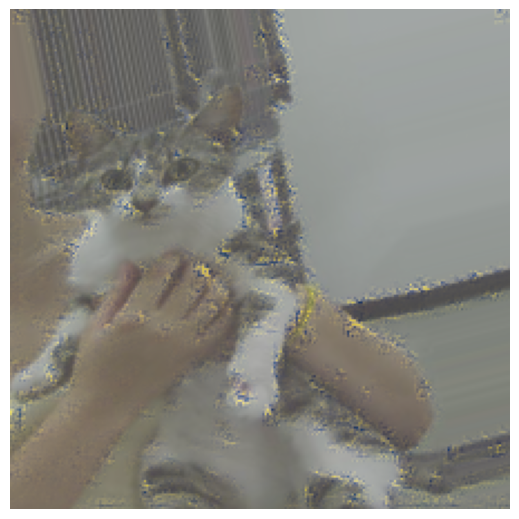

steps: 5 -> 0.16s


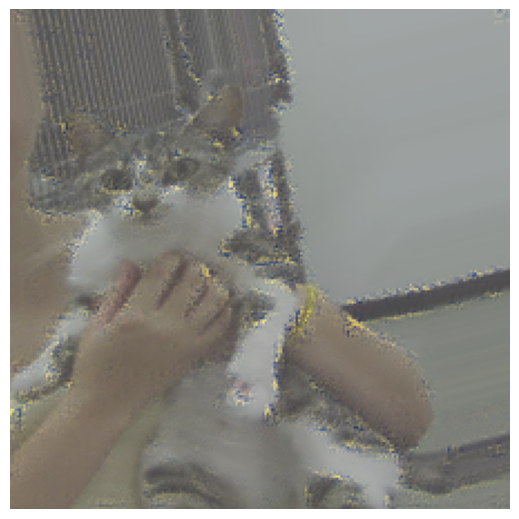

steps: 20 -> 0.28s


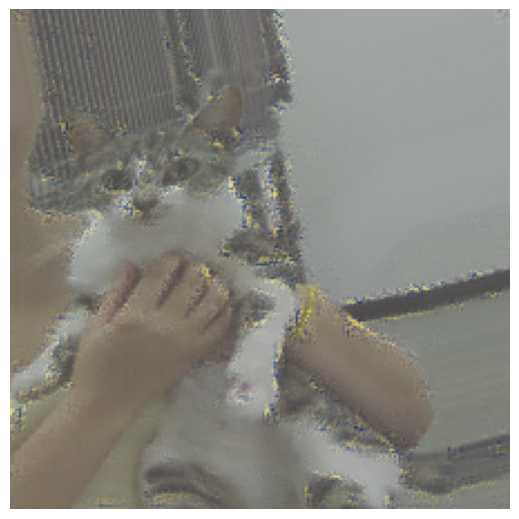

steps: 50 -> 0.31s


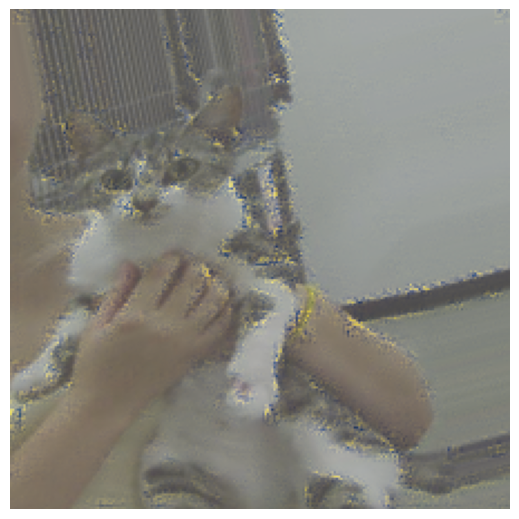

steps: 200 -> 1.36s


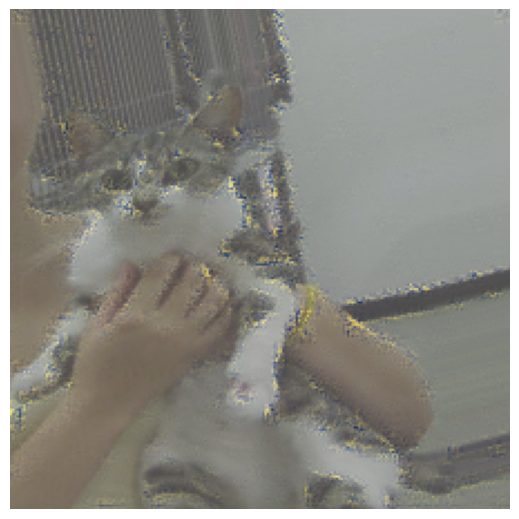

In [64]:
output_layer = -2
batch_size = 32
steps_list = [2, 5, 20, 50, 200]
baseline_value = 0

for steps in steps_list:
    t = time()
    explainer = IntegratedGradients(model,
                                    output_layer=output_layer, batch_size=batch_size,
                                    steps=steps, baseline_value=baseline_value)
    explanation = explainer.explain(x, y)
    print(f"steps: {steps} -> {round(time()-t, 2)}s")

    plot_attributions(explanation, x, img_size=5, cmap='cividis', alpha=0.6)
    plt.show()